# Satellite Map of the Telescope Array Cosmic Ray Observatory #
## Author : Greg Furlich
## Date : 2019-02-01
### Purpose : Pulling Landsat 8 data from AWS, creating a composite satellite image, zooming in on the telescape array cosmic ray observatory and overlaying information. 
More at [Telescope Array Composite Satellite Map using Landsat Data](https://gregfurlich.com/posts/telescope-array-satellite-map.html)

# Import Python Libraries #

In [1]:
import pandas as pd
import os, glob, wget
import matplotlib.pyplot as plt
from osgeo import gdal
import rasterio
import numpy as np
import math
import re

# Import Scene list file into Pandas DataFrame #
[Scene list download](https://landsat-pds.s3.amazonaws.com/c1/L8/scene_list.gz)

In [2]:
f = 'landsat_8_aws_scene_list_20200808'
df = pd.read_csv(f)
# Check Scene List #
print(df.shape)
display(df.tail())

(2039703, 12)


productId               entityId  \
2039698  LC08_L1GT_208004_20200806_20200807_01_RT  LC82080042020219LGN00   
2039699  LC08_L1TP_176062_20200806_20200807_01_RT  LC81760622020219LGN00   
2039700  LC08_L1TP_176079_20200806_20200807_01_RT  LC81760792020219LGN00   
2039701  LC08_L1TP_192036_20200806_20200807_01_RT  LC81920362020219LGN00   
2039702  LC08_L1TP_192044_20200806_20200807_01_RT  LC81920442020219LGN00   

                    acquisitionDate  cloudCover processingLevel  path  row  \
2039698  2020-08-06 11:27:39.935012       98.45            L1GT   208    4   
2039699  2020-08-06 08:32:59.402007       62.79            L1TP   176   62   
2039700  2020-08-06 08:39:46.324864        0.01            L1TP   176   79   
2039701  2020-08-06 10:01:30.892612        0.00            L1TP   192   36   
2039702  2020-08-06 10:04:42.059052       29.92            L1TP   192   44   

          min_lat   min_lon   max_lat   max_lon  \
2039698  76.76868  17.36822  79.20000  29.91599   
2039699  -3.94766  23.41179  -1.84473  25.46072   
2039700 -28.48941  17.69588 -26.37063  20.03246   
2039701  33.53324   7.12533  35.65588   9.66675   
2039702  22.04505   4.32692  24.16361   6.51721   

                                              download_url  
2039698  https://s3-us-west-2.amazonaws.com/landsat-pds...  
2039699  https://s3-us-west-2.amazonaws.com/landsat-pds...  
2039700  https://s3-us-west-2.amazonaws.com/landsat-pds...  
2039701  https://s3-us-west-2.amazonaws.com/landsat-pds...  
2039702  https://s3-us-west-2.amazonaws.com/landsat-pds...

# Find Scene Entires over Telescope Array with low cloud cover #

In [3]:
# Location of the TA Observatory in the Landsat 8 page #
CLF_path = 38
CLF_row = 33

clf_df = df[df['path'] == CLF_path]
clf_df = clf_df[clf_df['row'] == CLF_row]

## Turn acquisition time into datetime ##
clf_df['acquisitionDate'] = pd.to_datetime(clf_df['acquisitionDate'])

## Cut on cloud cover to less than 5% ##
clf_df = clf_df[clf_df['cloudCover'] < 5 ]

## Find a Spring Month (For aesthetics) ##
clf_df = clf_df[clf_df['acquisitionDate'].dt.month == 4]

## Sort by Most Recent Pass ##
clf_df = clf_df.sort_values('acquisitionDate',ascending=False)
display(clf_df.head())

productId               entityId  \
1948587  LC08_L1TP_038033_20200425_20200426_01_RT  LC80380332020116LGN00   
1971570  LC08_L1TP_038033_20200425_20200509_01_T1  LC80380332020116LGN00   
947415   LC08_L1TP_038033_20150428_20170301_01_T1  LC80380332015118LGN01   
947414   LC08_L1TP_038033_20150412_20170228_01_T1  LC80380332015102LGN02   

                   acquisitionDate  cloudCover processingLevel  path  row  \
1948587 2020-04-25 18:08:06.916571        3.24            L1TP    38   33   
1971570 2020-04-25 18:08:06.916571        3.24            L1TP    38   33   
947415  2015-04-28 18:07:52.232930        2.87            L1TP    38   33   
947414  2015-04-12 18:07:58.860876        2.49            L1TP    38   33   

          min_lat    min_lon   max_lat    max_lon  \
1948587  37.80464 -113.83262  39.94594 -111.09092   
1971570  37.80464 -113.83262  39.94594 -111.09092   
947415   37.80416 -113.85367  39.94543 -111.11137   
947414   37.80456 -113.83613  39.94586 -111.09092   

                                              download_url  
1948587  https://s3-us-west-2.amazonaws.com/landsat-pds...  
1971570  https://s3-us-west-2.amazonaws.com/landsat-pds...  
947415   https://s3-us-west-2.amazonaws.com/landsat-pds...  
947414   https://s3-us-west-2.amazonaws.com/landsat-pds...

# Land Sat 8 Info Data Frame #

In [4]:
# LandSat 8 Bands #
bands = [ 'B{0}'.format(i) for i in range(1,12)]

#Band	Wavelength range (nanometers)	Spatial Resolution (m)	Spectral Width (nm)
#Band 1 - Coastal aerosol	430 - 450	30	2.0
#Band 2 - Blue	450 - 510	30	6.0
#Band 3 - Green	530 - 590	30	6.0
#Band 4 - Red	640 - 670	30	0.03
#Band 5 - Near Infrared (NIR)	850 - 880	30	3.0
#Band 6 - SWIR 1	1570 - 1650	30	8.0
#Band 7 - SWIR 2	2110 - 2290	30	18
#Band 8 - Panchromatic	500 - 680	15	18
#Band 9 - Cirrus	1360 - 1380	30	2.0
# 10 	Long Wavelength Infrared 10.6-11.2 	100 m
# 11 	Long Wavelength Infrared 11.5-12.5 	100 m
band_names = ['Band 1', 'Band 2', 'Band 3', 'Band 4', 'Band 5', 'Band 6', 'Band 7', 'Band 8', 'Band 9','Band 10', 'Band 11']
band_type = ['Coastal aerosol','Blue', 'Green', 'Red', 'NIR', 'SWIR 1', 'SWIR 2', 'Panchromatic', 'Cirrus', 'Long Wavelength Infrared', 'Long Wavelength Infrared']
band_wl_i =[430,450,530,640,850,1570,2110,500,1360,10.6,11.5]
band_wl_f = [450,510,590,670,880,2650,2290,680,1380,11.2,12.5]
band_sr = [30,30,30,30,30,30,30,15,30,100,100]
band_wl_w = [2,6,6,.03,3,8,18,18,2,0,0]

landsat = {'bands':bands, 'band_names': band_names, 'band_type': band_type, 'band_wl_i': band_wl_i, 'band_wl_f':band_wl_f, 'band_sr':band_sr, 'band_wl_w':band_wl_w}
landsat_df = pd.DataFrame(landsat)
display(landsat_df)

bands band_names                 band_type  band_wl_i  band_wl_f  band_sr  \
0     B1     Band 1           Coastal aerosol      430.0      450.0       30   
1     B2     Band 2                      Blue      450.0      510.0       30   
2     B3     Band 3                     Green      530.0      590.0       30   
3     B4     Band 4                       Red      640.0      670.0       30   
4     B5     Band 5                       NIR      850.0      880.0       30   
5     B6     Band 6                    SWIR 1     1570.0     2650.0       30   
6     B7     Band 7                    SWIR 2     2110.0     2290.0       30   
7     B8     Band 8              Panchromatic      500.0      680.0       15   
8     B9     Band 9                    Cirrus     1360.0     1380.0       30   
9    B10    Band 10  Long Wavelength Infrared       10.6       11.2      100   
10   B11    Band 11  Long Wavelength Infrared       11.5       12.5      100   

    band_wl_w  
0        2.00  
1        6.00  
2        6.00  
3        0.03  
4        3.00  
5        8.00  
6       18.00  
7       18.00  
8        2.00  
9        0.00  
10       0.00

# Retrieve LandSat 8 TIFs from AWS #

## Format urls for retrieval ##

In [5]:
## Download Directory ##
dir = '/GDF/TAResearch/TAmap/Landsat_imgs'

# Select Scene to download #
map_df = clf_df.head(1)
display(map_df)

# Scene Download URL
download_url = str(map_df['download_url'].values[0])
# print download_url
productId = str(map_df['productId'].values[0])

# Format list of Images to download #
download_urls = download_url.replace('/index.html','/{0}'.format(productId))
download_urls = [ '{0}_{1}.TIF'.format(download_urls, band) for band in bands]
# print download_urls[0]

productId               entityId  \
1948587  LC08_L1TP_038033_20200425_20200426_01_RT  LC80380332020116LGN00   

                   acquisitionDate  cloudCover processingLevel  path  row  \
1948587 2020-04-25 18:08:06.916571        3.24            L1TP    38   33   

          min_lat    min_lon   max_lat    max_lon  \
1948587  37.80464 -113.83262  39.94594 -111.09092   

                                              download_url  
1948587  https://s3-us-west-2.amazonaws.com/landsat-pds...

## Download LandSat 8 TIFs from AWS for all bands ##
[LC08_L1TP_038033_20200425_20200426_01_RT](https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/038/033/LC08_L1TP_038033_20200425_20200426_01_RT/index.html)

In [6]:
# Make Image Directory to put pulled images #
img_dir = dir + '/' + productId
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

# Retrieve Images from AWS #
image_files = []
print('Saving to {0}'.format(img_dir))
for d in download_urls:
    image_file = img_dir + '/' + d.split('/')[-1]
    image_files.append(image_file)
#     print(image_file)
    if not os.path.isfile(img_dir+ '/'+d.split('/')[-1]):
        print('Retrieving {0}...'.format(d.split('/')[-1]))
        wget.download(d, out=img_dir)
    elif os.path.isfile(d.split('/')[-1]): print('{0} already exists...'.format(d.split('/')[-1]))

Saving to /GDF/TAResearch/TAmap/Landsat_imgs/LC08_L1TP_038033_20200425_20200426_01_RT


## Creating Satellite of the whole Scene ##

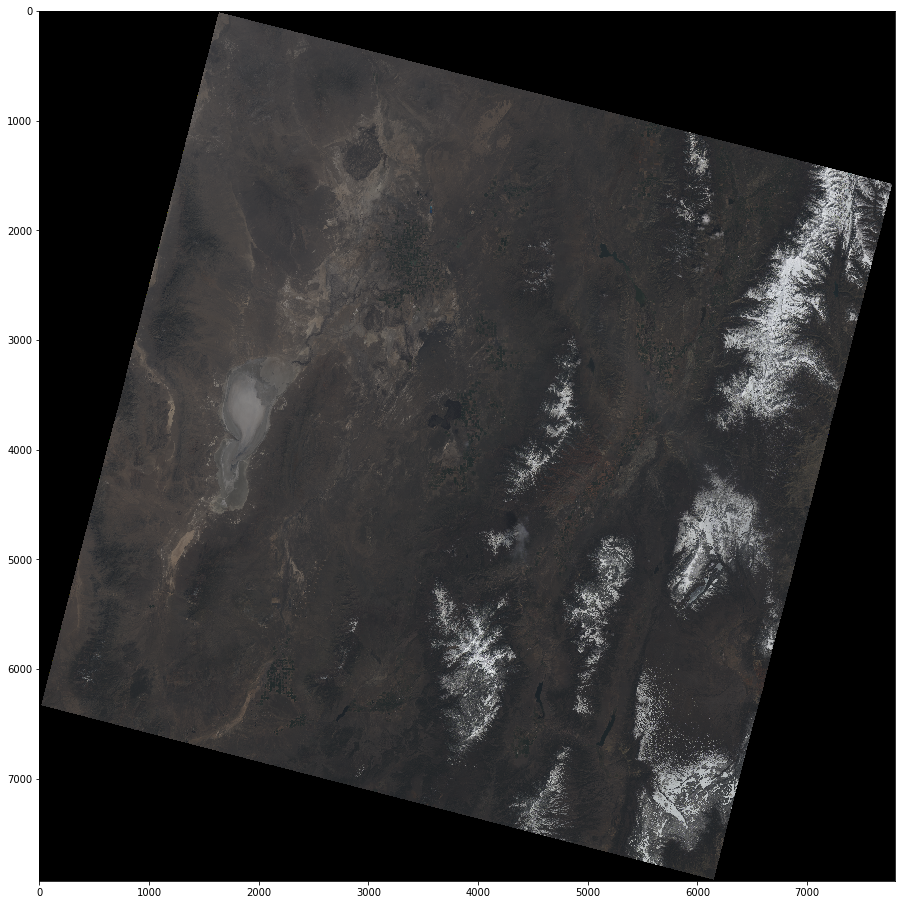

In [7]:
def norm(band):
    '''
    Normalize Spectrum Bands for Composite Image
    '''
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))

# Open Bands Using GDAL #
b = gdal.Open(image_files[1])
g = gdal.Open(image_files[2])
r = gdal.Open(image_files[3])

# call the norm function on each band as array converted to float
b2 = norm(b.ReadAsArray().astype(np.float))
b3 = norm(g.ReadAsArray().astype(np.float))
b4 = norm(r.ReadAsArray().astype(np.float))

# Create RGB Composite #
rgb = np.dstack((b4,b3,b2))

# Show Composite Image #
plt.figure(figsize=(16,16))
plt.imshow(rgb)
plt.savefig(productId+'.svg')
plt.savefig(productId+'.png', dpi=300)

# Telescope Array Site Info #

In [8]:
site_name = ['Central Laser Facility','Black Rock Mesa','Long Ridge', 'Middle Drum']
site = ['CLF','BR','LR','MD']
site_color = ['blue', 'red', 'green', 'purple']

# GPS decimal Coordinates #
lat_dd = [39.29693,39.18830,39.20792,39.47282]
long_dd = [-112.90875,-112.71170,-113.12147,-112.99366]

# CLF Coordinates #
alt_m = [1382,1404,1554,1600]
clf_x_km = [0,17.02811,-18.37754,-7.30807]
clf_y_km = [0,-12.0442,-9.86272,19.53612]
clf_z_km = [0,-.012095,.137922,.183828]

# FOV in CW from North #
fov_azm_i = [0, 242, 18, 102]
fov_azm_f = [0, 350, 125, 218]

# GPS Locations #
lat_deg = [39, 39, 39, 39]
long_deg = [112, 112, 113, 112]
lat_min = [17, 11, 12, 28]
long_min = [54, 42, 7, 59]
lat_sec = [48.44864, 18.09744, 28.32926, 22.04278]
long_sec = [31.81968, 45.44298, 14.24482, 39.15719]
lat = [ deg +  min/60 + sec/3600 for (deg, min, sec) in zip(lat_deg, lat_min, lat_sec)]
long = [ -1 * (deg +  min/60 + sec/3600) for (deg, min, sec) in zip(long_deg, long_min, long_sec)]

# Create a dictionary of site into #
TA = {'Site Name': site_name,
      'Site': site,
      'Color': site_color,
      'Latitude': lat,
      'Longitude': long,
      'Altitude': alt_m,
      'X': clf_x_km,
      'Y': clf_y_km,
      'Z': clf_z_km,
      'FOVi': fov_azm_i,
      'FOVf': fov_azm_f,
      'Latitude DD': lat_dd,
      'Longitude DD': long_dd,}

## Convert Dictionary to Pandas DF ##
ta_df = pd.DataFrame(TA)
display(ta_df)

Site Name Site   Color   Latitude   Longitude  Altitude  \
0  Central Laser Facility  CLF    blue  39.296791 -112.908839      1382   
1         Black Rock Mesa   BR     red  39.188360 -112.712623      1404   
2              Long Ridge   LR   green  39.207869 -113.120624      1554   
3             Middle Drum   MD  purple  39.472790 -112.994210      1600   

          X         Y         Z  FOVi  FOVf  Latitude DD  Longitude DD  
0   0.00000   0.00000  0.000000     0     0     39.29693    -112.90875  
1  17.02811 -12.04420 -0.012095   242   350     39.18830    -112.71170  
2 -18.37754  -9.86272  0.137922    18   125     39.20792    -113.12147  
3  -7.30807  19.53612  0.183828   102   218     39.47282    -112.99366

# Center and Zoom on Central Laser Facilty (Point of Interest) #

## Center on Point of Interest Function ##

In [9]:
def centerPOI(max_lat, 
    min_lat, 
    max_lon, 
    min_lon, 
    raster, 
    poi_lat = ta_df[ta_df['Site'] == 'CLF']['Latitude'].values[0], 
    poi_lon = ta_df[ta_df['Site'] == 'CLF']['Longitude'].values[0], 
    pixels = 2000):
    '''
    Create a Window for the Rasters to Center on a Point of Interest (POI) within the Raster with given latitude and longitude of site.
    poi_lat = POI latitude in Degrees Decimal
    poi_lon = POI longitude in Degrees Decimal
    p = width of window in pixels. Each Pixel is 30m in width
    
    '''
    # Raster Longitude and Latitude Width #
    lon_range = max_lat - min_lat
    lat_range = max_lon - min_lon
#     print(max_lat, min_lat, lon_range)
#     print(max_lon, min_lon, lat_range)

    # Relative Position of POI #
    poi_x = (poi_lon - clf_df['min_lon'].values[0]) / lon_range
    poi_y = 1 - (poi_lat - clf_df['min_lat'].values[0]) / lat_range # Flipped y axis # 
    
    # Open Raster and Find Size #
    raster =  gdal.Open(raster)
    dx, dy = raster.RasterXSize, raster.RasterYSize

    # Find Position of POI in Raster #
    poi_x = poi_x * dx
    poi_y = poi_y * dy

    # Calculate Window for Focus on POI #
    # Window Corner #
    x_o, y_o = poi_x - .5 * pixels, poi_y - .5 * pixels
    # Window Width #
    d_x, d_y = pixels, pixels
    window = rasterio.windows.Window(x_o, y_o, d_x, d_y)
    
    return window

## Center Scene on CLF ##

In [10]:
# Determine the Corners of the Scene #
lon_range = clf_df['max_lon'].values[0] - clf_df['min_lon'].values[0]
lat_range = clf_df['max_lat'].values[0] - clf_df['min_lat'].values[0]
# print(clf_df['max_lon'].values[0], clf_df['min_lon'].values[0], lon_range)
# print(clf_df['max_lat'].values[0], clf_df['min_lat'].values[0], lat_range)

# Determine where the CLF is relative to the corners
clf_lon, clf_lat = -112.90875, 39.29693
md_lon, md_lat = -112.99366 , 39.47282
lr_lon, lr_lat = -113.12147, 39.20792
br_lon, br_lat = -112.71170, 39.18830
clf_x = (br_lon - clf_df['min_lon'].values[0]) / lon_range
clf_y = 1 - (br_lat - clf_df['min_lat'].values[0]) / lat_range

# print(clf_x,clf_y)

# Open the raster #
raster =  gdal.Open(image_files[3])
# print image_files[3]

# Determine the pixel size of raster #
dx, dy = raster.RasterXSize, raster.RasterYSize
# print(dx, dy)
pixel_range = 200
clf_x = clf_x * dx
clf_y = clf_y * dy
# print(clf_x,clf_y)

# Determine center of TA given pixel size #
x_o, y_o = clf_x - .5 * pixel_range, clf_y - .5 * pixel_range
d_x,d_y = pixel_range, pixel_range
window = rasterio.windows.Window(x_o, y_o, d_x, d_y)

# print(window)

## Load RGB Bands of Scene #

In [11]:
# Create Window #
window = centerPOI(poi_lat = ta_df[ta_df['Site'] == 'CLF']['Latitude'].values[0], 
              poi_lon = ta_df[ta_df['Site'] == 'CLF']['Longitude'].values[0], 
              max_lat = map_df['max_lon'].values[0], 
              min_lat = map_df['min_lon'].values[0], 
              max_lon = map_df['max_lat'].values[0], 
              min_lon = map_df['min_lat'].values[0], 
              raster = image_files[3], 
              pixels = 2000)

# print(window)

# Load RGB Bands #
r = rasterio.open(image_files[3]).read(1, window=window)
g = rasterio.open(image_files[2]).read(1, window=window)
b = rasterio.open(image_files[1]).read(1, window=window)
pan = rasterio.open(image_files[8]).read(1, window=window)

# Normalize RGB Bands #
b2 = norm(b.astype(np.float))
b3 = norm(g.astype(np.float))
b4 = norm(r.astype(np.float))
b8 = norm(pan.astype(np.float))
print(np.shape(b4))

# Create RGB Composite by stacking layers #
rgb = np.dstack((b4,b3,b2))
print(np.shape(rgb))

(2000, 2000)
(2000, 2000, 3)


## Histogram of RGB Spectrums ##

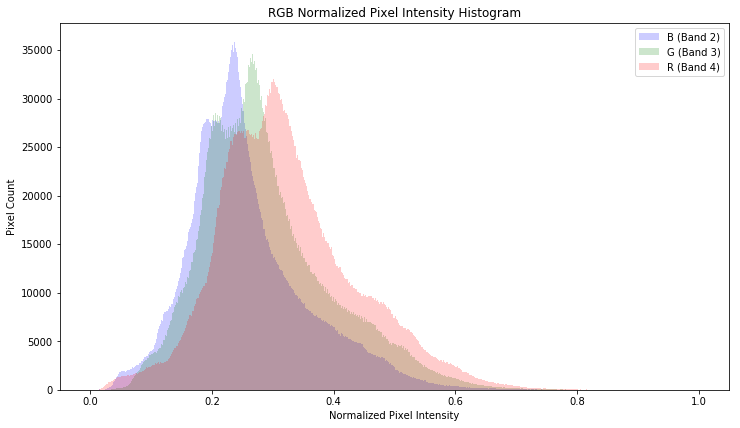

In [12]:
plt.figure(figsize=(12,6.75))
plt.hist(b2.ravel(), alpha=.2, color='blue',bins='auto',label='B (Band 2)')  # arguments are passed to np.histogram
plt.hist(b3.ravel(), alpha=.2, color='green',bins='auto',label='G (Band 3)')
plt.hist(b4.ravel(), alpha=.2, color='red',bins='auto',label='R (Band 4)')
plt.title('RGB Normalized Pixel Intensity Histogram')
plt.ylabel('Pixel Count')
plt.xlabel('Normalized Pixel Intensity')
plt.legend()
plt.savefig('pixel_histogram.svg')
plt.savefig('pixel_histogram.png', dpi=300)

# Plot Composite Satelite Image Centered on CLF #

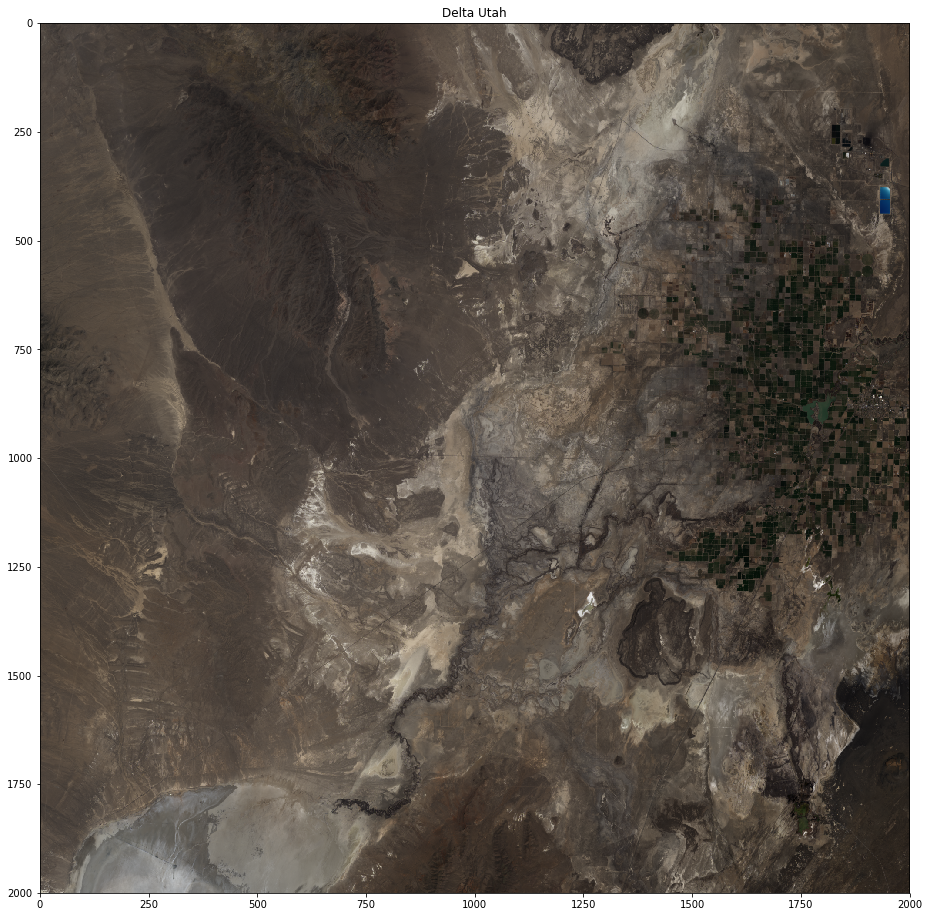

In [13]:
plt.figure(figsize=(16,16))
plt.imshow(rgb)
plt.title('Delta Utah')
plt.savefig('ta_array.png', dpi=300)
plt.savefig('delta.svg')


# Satellite Image of Each Telescope FD site and CLF #

1 CLF 39.29679128888889 -112.90883880000001
2 BR 39.18836039999999 -112.71262305
3 LR 39.20786923888889 -113.1206235611111
4 MD 39.472789661111115 -112.99421033055556


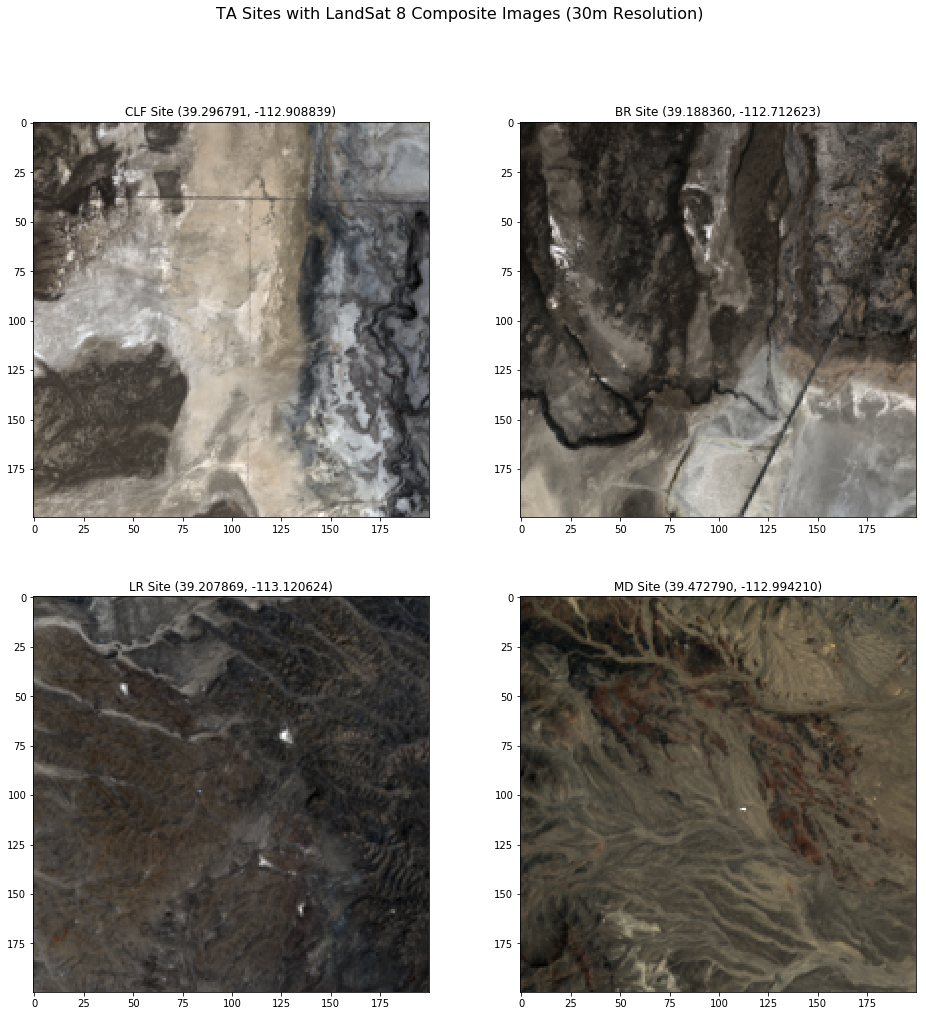

In [14]:
## Create An Image of Each Site Zoomed in ##
fig = plt.figure(figsize=(16,16))
for (i, site, lat, lon) in zip(range(1,len(ta_df)+1),ta_df['Site'].values,ta_df['Latitude'].values,ta_df['Longitude'].values):
    plt.subplot(2,2,i)
    print(i, site, lat, lon)
    
    ## Finding Offset from recorded CLF lat and Long values to Center CLF ##
    lat_offset, lon_offset = -.015, -.017
    
    # Create Window #
    window = centerPOI(poi_lat = lat + lat_offset, 
              poi_lon = lon +  lon_offset, 
              max_lat = map_df['max_lon'].values[0], 
              min_lat = map_df['min_lon'].values[0], 
              max_lon = map_df['max_lat'].values[0], 
              min_lon = map_df['min_lat'].values[0], 
              raster = image_files[3], 
              pixels = 200)

    # Load Bands #
    r = rasterio.open(image_files[3]).read(1, window=window)
    g = rasterio.open(image_files[2]).read(1, window=window)
    b = rasterio.open(image_files[1]).read(1, window=window)

    # Normalize Bands #
    b2 = norm(b.astype(np.float))
    b3 = norm(g.astype(np.float))
    b4 = norm(r.astype(np.float))

    # Stack RGB for Composite #
    rgb = np.dstack((b4,b3,b2))

    # Plot Site #
    plt.imshow(rgb)
    plt.title('{0} Site ({1:.6f}, {2:.6f})'.format(site,lat,lon))
    
fig.suptitle('TA Sites with LandSat 8 Composite Images (30m Resolution)', fontsize=16)
plt.savefig('ta_sites.svg')
plt.savefig('ta_sites.png', dpi=300)

# Correct Offset of lat and lon of image (First Approximation) #

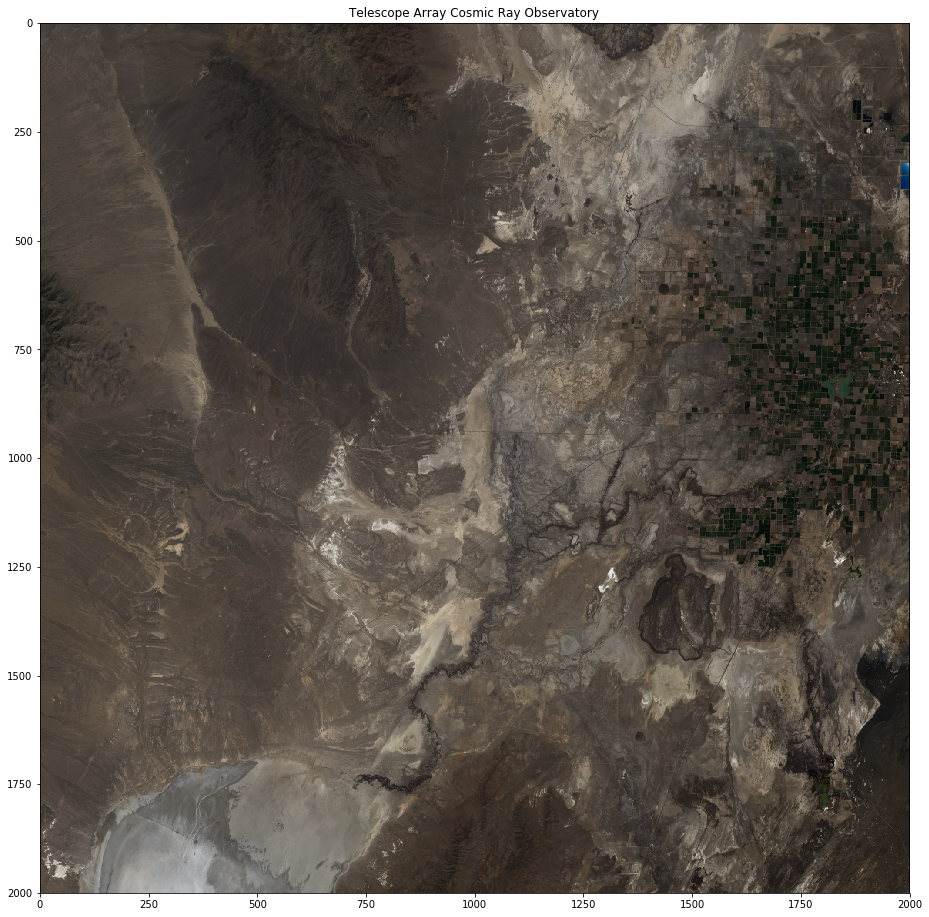

In [15]:
## Finding Offset from recorded CLF lat and Long values to Center CLF ##
lat_offset, lon_offset = -.015, -.017
    
    # Create Window #
window = centerPOI(poi_lat = ta_df[ta_df['Site'] == 'CLF']['Latitude'].values[0] + lat_offset, 
              poi_lon = ta_df[ta_df['Site'] == 'CLF']['Longitude'].values[0] + lon_offset, 
              max_lat = map_df['max_lon'].values[0], 
              min_lat = map_df['min_lon'].values[0], 
              max_lon = map_df['max_lat'].values[0], 
              min_lon = map_df['min_lat'].values[0], 
              raster = image_files[3], 
              pixels = 2000)

# print(window)

# Load Bands #
r = rasterio.open(image_files[3]).read(1, window=window)
g = rasterio.open(image_files[2]).read(1, window=window)
b = rasterio.open(image_files[1]).read(1, window=window)
pan = rasterio.open(image_files[8]).read(1, window=window)

# Normalize Bands #
b2 = norm(b.astype(np.float))
b3 = norm(g.astype(np.float))
b4 = norm(r.astype(np.float))
b8 = norm(pan.astype(np.float))

# Create RGB Composite #
rgb = np.dstack((b4,b3,b2))

plt.figure(figsize=(16,16))
plt.imshow(rgb)
plt.title('Telescope Array Cosmic Ray Observatory')
plt.savefig('ta_array.png', dpi=300)
plt.savefig('ta_array.svg')

## Create Field of View Arcs for site ##

In [16]:
def FOV_arc(r,ang_i,ang_f,xo,yo):
    d_ang = 100
    ang = np.linspace(ang_i,ang_f,d_ang)
    ring_x = r * np.sin(ang * np.pi / 180) + xo
    ring_y = r * np.cos(ang * np.pi / 180) + yo
    ring_x = np.concatenate(([xo],ring_x,[xo]))
    ring_y = np.concatenate(([yo],ring_y,[yo]))
    
    return ring_x, ring_y

## Haversine Formula and CLF Coordinates ##

In [17]:
def haversine(longitude_1, latitude_1, longitude_2, latitude_2):
    """
    Calculate the great circle distance between two points p1 and p2
    on the earth (specified in decimal degrees)
    """
    
    # convert decimal degrees to radians #
    longitude_1, latitude_1, longitude_2, latitude_2 = map(math.radians, [longitude_1, latitude_1, longitude_2, latitude_2])

    # haversine formula #
    dlongitude = longitude_2 - longitude_1 
    dlatitude = latitude_2 - latitude_1 
    a = math.sin(dlatitude/2)**2 + math.cos(latitude_1) * math.cos(latitude_2) * math.sin(dlongitude/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    
    # Earth Radius in m from wikipedia #
    radius = [6378100, 6356800, 6378137, 6356752.3141, 6399593.6259, 
              6371008.7714, 6371007.1810, 6371000.7900, 6378137.0, 
              6356752.3142, 6399593.6258, 6371008.7714, 6371007.1809, 
              6371000.7900, 6378137.0, 6356752.314140, 6335439, 
              6384400, 6352800, 6371230]
    description = [
        'nominal \"zero tide\" equatorial',
        'nominal \"zero tide\" polar ',
        'equatorial radius',
        'semiminor axis (b)',
        'polar radius of curvature (c)',
        'mean radius (R1)',
        'radius of sphere of same surface (R2)',
        'radius of sphere of same volume (R3)',
        'WGS-84 ellipsoid, semi-major axis (a)',
        'WGS-84 ellipsoid, semi-minor axis (b)',
        'WGS-84 ellipsoid, polar radius of curvature (c)',
        'WGS-84 ellipsoid, Mean radius of semi-axes (R1)',
        'WGS-84 ellipsoid, Radius of Sphere of Equal Area (R2)',
        'WGS-84 ellipsoid, Radius of Sphere of Equal Volume (R3)',
        'GRS 80 semi-major axis (a)',
        'GRS 80 semi-minor axis (b)',
        'meridional radius of curvature at the equator',
        'Maximum (the summit of Chimborazo)',
        'Minimum (the floor of the Arctic Ocean)',
        'Average distance from center to surface'
    ]
    
    R_Earth = {'r': radius, 'description': description}
    R_Earth = pd.DataFrame(R_Earth)
    
    # Radius of the Earth in km #
    r = (R_Earth['r'][3] + ta_df['Altitude'][0])/ 1000
    #r = R_Earth['r'][3]/ 1000
    
    # Bearing Angle CW from North
    bearing = math.atan2(math.sin(longitude_2-longitude_1)*math.cos(latitude_2), math.cos(latitude_1)*math.sin(latitude_2)-math.sin(latitude_1)*math.cos(latitude_2)*math.cos(longitude_2-longitude_1))
 
    # Great Circle Distance #
    d = c * r
    
    # Convert Bearing Angle to degrees #
    # bearing = bearing * 180 / pi
        
    return d, bearing

def CLF_coord(longitude, latitude):
    '''
    Calculates the x and y components of distance between a a point with decimal degree longitude, latitude.
    CLF Coordinates :
    +x : East [m]
    +y : North [m]
    '''
    clf_longitude, clf_latitude = ta_df['Longitude'][0], ta_df['Latitude'][0]
    
    d, bearing = haversine(clf_longitude, clf_latitude, longitude, latitude)
        
    # Find the x and y component of the Distance #
    x = d * math.sin(bearing)
    y = d * math.cos(bearing)
    
    return x, y

## Import Surface Detector (SD) Positions ##

In [18]:
# import SD .gpx file #
file_gps = '/GDF/TAResearch/TAmap/TASD.gpx' 

sd_lat = []
sd_lon = []
sd_id = []
sd_cmt = []
sd_alt = []
fgps = open(file_gps,'r')
for line in fgps.readlines():
#     print(line)
    # Find Lat and Lon #
    if re.findall('<wpt lat="([-0-9\.]+)" lon="([-0-9\.]+)">', line):
        latlon = re.findall('<wpt lat="([-0-9\.]+)" lon="([-0-9\.]+)">', line)
        sd_lat.append(float(latlon[0][0]))
        sd_lon.append(float(latlon[0][1])) 
    # Find ID #
    if re.findall('<name>([0-9]+)</name>', line):
        id = re.findall('<name>([0-9]+)</name>', line)
        sd_id.append(int(id[0]))
    # Find Comm Tower ##
    if re.findall('<cmt>(\D+)</cmt>', line):
        cmt = re.findall('<cmt>(\D+)</cmt>', line)
        sd_cmt.append(cmt[0])
    # Find Altitude #
    if re.findall('ele>([0-9\.]+)</ele>', line):
        alt = re.findall('<ele>([0-9\.]+)</ele>', line)
        sd_alt.append(float(alt[0]))

sd_x, sd_y = [], []
for (lat,lon) in zip(sd_lat,sd_lon):
    x, y = CLF_coord(lon, lat)
    sd_x.append(x)
    sd_y.append(y)
    
# sd_x, sd_y = [ x, y = CLF_coord(lon, lat) for (lat,lon) in zip(sd_lat,sd_lon)] 
sd_df = {'Latitude':sd_lat,'Longitude':sd_lon,'ID':sd_id,'altitude':sd_alt,'Communication Tower':sd_cmt,'X':sd_x,'Y':sd_y}

sd_df = pd.DataFrame(sd_df)

sd_df.to_csv('sd_loc.csv',index=False)

display(sd_df.head())

Latitude  Longitude   ID  altitude Communication Tower          X  \
0  39.18403 -113.06582  106   1514.02                  LR -13.502807   
1  39.19500 -113.06521  107   1497.08                  LR -13.448237   
2  39.20562 -113.06496  108   1487.89                  LR -13.424705   
3  39.21656 -113.06511  109   1490.37                  LR -13.435509   
4  39.22761 -113.06534  110   1490.11                  LR -13.453164   

           Y  
0 -12.501457  
1 -11.284204  
2 -10.105736  
3  -8.891699  
4  -7.665443

# TA Satellite Map with Information Overlayed #

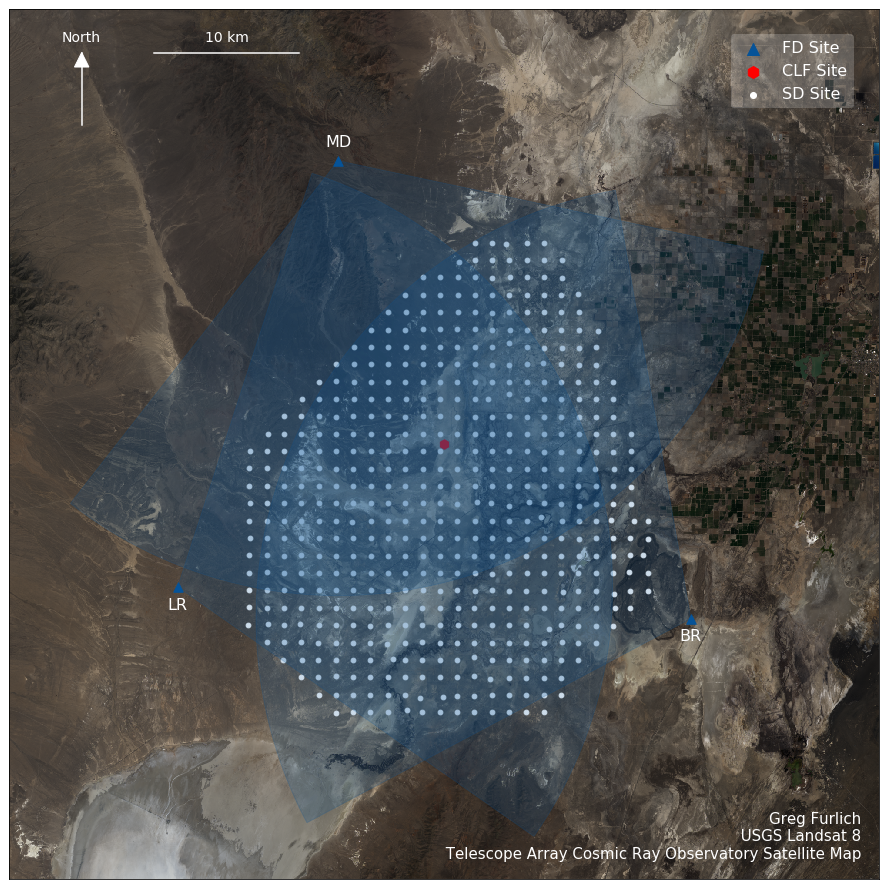

In [19]:
## Finding Offset from recorded CLF lat and Long values to Center CLF ##
lat_offset, lon_offset = -.019, -.02

# Create Window #
window = centerPOI(poi_lat = ta_df[ta_df['Site'] == 'CLF']['Latitude'].values[0] + lat_offset, 
              poi_lon = ta_df[ta_df['Site'] == 'CLF']['Longitude'].values[0] + lon_offset, 
              max_lat = map_df['max_lon'].values[0], 
              min_lat = map_df['min_lon'].values[0], 
              max_lon = map_df['max_lat'].values[0], 
              min_lon = map_df['min_lat'].values[0], 
              raster = image_files[3], 
              pixels = 2000)

# Load Bands #
r = rasterio.open(image_files[3]).read(1, window=window)
g = rasterio.open(image_files[2]).read(1, window=window)
b = rasterio.open(image_files[1]).read(1, window=window)

# Normalize Bands #
b2 = norm(b.astype(np.float))
b3 = norm(g.astype(np.float))
b4 = norm(r.astype(np.float))

# Create RGB Composite #
rgb = np.dstack((b4,b3,b2))

# FOV Rings #
FOV_x, FOV_y = [], []
FOV_c = []   
for (ang_i, ang_f, xo, yo, color) in zip(ta_df['FOVi'].values,ta_df['FOVf'].values,ta_df['X'].values,ta_df['Y'].values,ta_df['Color'].values):
    r = 30
    x, y = FOV_arc(r, ang_i, ang_f, xo, yo)
    FOV_x.append(x)
    FOV_y.append(y)
    FOV_c.append(color)
    
## Composite Array Plot ##
fig = plt.figure(figsize=(16,16))

# Satellite Background #
ax=fig.add_subplot(111)
ax.imshow(rgb)
ax.tick_params(size=0)
ax.set_aspect('equal')
ax.set_yticklabels([])
ax.set_xticklabels([])

# FD Site Back Grounds #
clr_clf = 'red'
clr_fd = '#065398'
clr_sd = 'white'

ax2 = fig.add_subplot(111, frame_on=False)

# Plot FOV #
for (x,y,c) in zip(FOV_x, FOV_y, FOV_c):
    if x[0] != 0 :
        alpha = .2
        ax2.fill(x,y,color=clr_fd,alpha=alpha)
        
# FD Sites #
# for (lat,lon,color,label) in zip(ta_df['Latitude DD'],ta_df['Longitude DD'],ta_df['Color'],ta_df['Site']):
#     x, y = CLF_coord(lon,lat)
for (x,y,label) in zip(ta_df['X'],ta_df['Y'],ta_df['Site']):
    if label == 'CLF' : ax2.scatter(x,y,marker='h', s=90, color=clr_clf)
    else : ax2.scatter(x,y,marker='^', s=90, color=clr_fd)
# SD Sites #
for (x,y) in zip(sd_df['X'],sd_df['Y']):
    ax2.scatter(x,y,marker='.', s=90, color=clr_sd)
# Label Sites #
for (x,y,text) in zip(ta_df['X'],ta_df['Y'],ta_df['Site']):
    #print (x,y,color,label)
    if text != 'CLF':
        if text == 'MD':
            ax2.text(x,y + 1.25,text, verticalalignment='center', horizontalalignment='center', fontsize=16, color='white')
        else :
            ax2.text(x,y - 1.25,text, verticalalignment='center', horizontalalignment='center', fontsize=16, color='white')
ax2.set_xlim([-30,30])
ax2.set_ylim([-30,30])
ax2.tick_params(size=0)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
       
# Stuff for Legend #
ax2.scatter(40,40,marker='^',color=clr_fd, label='FD Site')
ax2.scatter(40,40,marker='h',color=clr_clf, label='CLF Site')
ax2.scatter(40,40,marker='.',color=clr_sd, label='SD Site')

# Scale #
ax2.plot([-20,-10],[27,27],color='white')
ax2.text(-15, 28, '10 km', verticalalignment='center', horizontalalignment='center', color='white', fontsize=14)

# North Compass #
ax2.plot([-25,-25],[22,27],color='white')
ax2.text(-25, 28, 'North', verticalalignment='center', horizontalalignment='center', color='white', fontsize=14)
ax2.fill([-25,-25.5,-24.5],[27,26,26],color='white')

## Attribution ##
ax.text(0.98, 0.02, 'Greg Furlich\n USGS Landsat 8\n Telescope Array Cosmic Ray Observatory Satellite Map',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        weight='medium',
        color='white', fontsize=15)

# Plot Info #
# plt.title('Telescope Array Cosmic Ray Observatory')
# plt.xlabel('East [km]')
# plt.ylabel('North [km]')

leg =plt.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98), prop={'size':16}, markerscale=2, framealpha = .2)
frame = leg.get_frame()
frame.set_color('white')
frame.set_linewidth(0)
for text in leg.get_texts():
    plt.setp(text, color = 'w')
    
ax2.set_aspect('equal')

# plt.show()
plt.savefig('ta_map.svg', bbox_inches='tight', pad_inches=-.1)
plt.savefig('ta_map.png', bbox_inches='tight', pad_inches=-.1, dpi=300)